In [9]:
import math
import statistics
import random
import numpy as np

import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count
from PIL import Image
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from itertools import count

from tensorboardX import SummaryWriter

#from env import MancalaEnv
from game import Game
from randomagent import AgentRandom
from exactagent import AgentExact
from maxagent import AgentMax

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model Architecture

In [11]:
class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_dim, action_dim, hidden_dim, lr = 0.001):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
       self.criterion = torch.nn.MSELoss()
       self.


    def update(self, st)
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,fc3_unit)
        self.fc4 = nn.Linear(fc3_unit,fc4_unit)
        self.fc5 = nn.Linear(fc4_unit,action_size)
        self.out = nn.Softmax(dim=1)
        
    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.out(x)
        return x

## Environment Variables

In [12]:
BUFFER_SIZE = int(1e6)  #replay buffer size
''' TRY AN ARRAY HERE FOR BATCH SIZE EFFECT '''
BATCH_SIZE = 2000        # minibatch size
GAMMA = 0.9            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 50        # how often to update the network
NUM_STATES = 14
NUM_ACTIONS = 6

## DQN Agent

In [13]:
class DQNAgent():
    """Interacts with and learns form environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn

            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
    def act(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        ## TODO: compute and minimize the loss
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim) = (64,4)
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
    
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones))
        
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Reward Functions

In [14]:
def sparse_reward(game, idx):
    done = game.over()
    next_state = np.array(game.board())
    dqn_score, agent_score = game.score()
    win = False
    if((dqn_score > agent_score) and done):
        reward = 1
        win = True 
    else:
        reward = -1
    return(next_state, reward, done, win)

def keep_ahead_reward(game, idx):
    done = game.over()
    next_state = np.array(game.board())
    dqn_score, agent_score = game.score()
    win = False

    if((dqn_score - agent_score) > 0):
        reward = 1
    else:
        reward = 0
    
    if((dqn_score > agent_score) and done):
        win = True
        reward = 10

    return(next_state, reward, done, win)

def dont_fall_behind_reward(game, idx):
    done = game.over()
    next_state = np.array(game.board())
    dqn_score, agent_score = game.score()
    win = False
    if((dqn_score - agent_score) < 0):
        reward = -1
    else:
        reward = 0

    if((dqn_score > agent_score) and done):
        win = True 
        reward = 10

    return(next_state, reward, done, win)

## Train The agent

In [15]:
agent = DQNAgent(state_size=NUM_STATES, action_size=NUM_ACTIONS, seed=0)
opponent = AgentRandom()
'''
Take a Look at Epsilons
'''
def dqn(n_episodes= 100, max_t = 1000, eps_start=0.3, eps_end = 0.01,
       eps_decay=0.99):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
        
    """
    scores = [] # list containing score from each episode
    winsarray = np.zeros(shape = (1,3)) # Story which episode saw wins

    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start
    for i_episode in tqdm(range(1, n_episodes+1)):
        game = Game() # Reset Env
        score = 0       # Reset Score
        done = False    # Reset finished (done) flag
        win = False
        state = np.array(game.board()) # Reset State and convert it to numpy array
        episode_length = 0

        while not done:
            episode_length += 1
            action = agent.act(state,eps) # Select an action
            ''' TAKING AN ACTION '''
            game.move(action) # Take the action on the Game board

            next_state, reward, done, win = keep_ahead_reward(game, i_episode) # Get next state, reward and if game is done as result of action

            game._player_one = False
            game.move(opponent._move(game))
            game._player_one = True
            #next_state, reward, done, win = keep_ahead_reward(game)
            agent.step(state,action,reward,next_state,done)

            

            
            ## above step decides whether we will train(learn) the network
            ## actor (local_qnetwork) or we will fill the replay buffer
            ## if len replay buffer is equal to the batch size then we will
            ## train the network or otherwise we will add experience tuple in our 
            ## replay buffer.
            state = next_state
            score += reward

            if done:
                if win:
                    winsarray = np.append(winsarray, [[i_episode,1,episode_length]], axis = 0)
                    break
                else:
                    winsarray = np.append(winsarray, [[i_episode,0,episode_length]], axis = 0)
                    break
            scores_window.append(score) ## save the most recent score
            scores.append(score) ## sae the most recent score
            eps = max(eps*eps_decay,eps_end)## decrease the epsilon
            '''
            print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode,np.mean(scores_window)), end="")
            if i_episode %100==0:
                print('\rEpisode {}\tAverage Score {:.2f}'.format(i_episode,np.mean(scores_window)))

            SAVE ENVIRONMENT IF SOLVED (WE DON'T KNOW WHAT SOLVED IS JUST YET)
            if np.mean(scores_window)>=200.0:
                print('\nEnvironment solve in {:d} epsiodes!\tAverage score: {:.2f}'.format(i_episode-100,
                                                                                           np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(),'checkpoint.pth')
           
                break
            '''
    return (winsarray, eps)

In [16]:
print("Compiled")

Compiled


In [17]:
N_EPISDOES = 20000
scores,eps = dqn(n_episodes = N_EPISDOES)
print(eps)

100%|██████████| 20000/20000 [54:13<00:00,  6.15it/s]0.01



## Moving Average

<function matplotlib.pyplot.show(*args, **kw)>

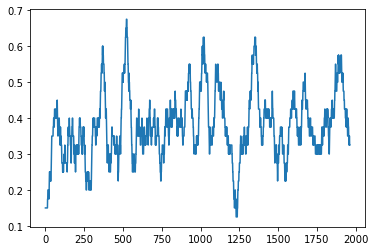

In [104]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

avg = moving_average(scores[:,1], 40)

plt.plot(avg)
plt.show
